In [2]:
#Importing Data from the CSV file
%matplotlib inline
import string
import math
import numpy as np

f_train = open("training.1600000.processed.noemoticon.csv", "r", encoding="ISO-8859-1")
X_train = f_train.readlines()
f_test = open("testdata.manual.2009.06.14.csv", "r")
X_test = f_test.readlines()

#Creating the List with just the tweets and finding the number of positive and negative classes. (TRAINING) 
#class_0 = number of classes with label = 0
#class_4 = number of classes with label = 4

class_0=class_4=0
tweets_train =[]
for x in X_train:
    a = x.split('","')
    if (a[0] == '"0'): class_0+=1
    else: class_4+=1
    tweets_train.append('%s"|"%s' % (a[0],a[-1]))

#Creating the List with just the tweets (TEST DATA)
tweets_test =[]
for x in X_test:
    a = x.split('","')
    tweets_test.append('%s"|"%s' % (a[0], a[-1]))
    
print("The length of the training set is = ", len(X_train))
print("The number of classes (label=4) =", class_4)
print("The number of classes (label=0) =", class_0)
print("The length of the test set is = ", len(X_test))

f_test.close()
f_train.close()

The length of the training set is =  1600000
The number of classes (label=4) = 800000
The number of classes (label=0) = 800000
The length of the test set is =  359


In [3]:
#Writing the tweets to a file (not necessary - REMOVE if not used anywhere later)
!rm -rf tweet_test.txt
!rm -rf tweet_train.txt
f = open("tweet_train.txt", "w")
for x in tweets_train:
    f.write(x)
f.close()

f = open("tweet_test.txt", "w")
for x in tweets_test:
    f.write(x)
f.close()

In [48]:
dictionary = {}
dict_0 = {}
dict_4 = {}
n = []
n_0 =[]
n_4 =[]
for x in tweets_train:
    x = x.rstrip("\n\r")
    x = x.split("|")
    twt = x[1].translate(str.maketrans('','',string.punctuation)).lower()
    words = twt.split() # if I use split(" "), it takes more than one white space as a word
    n.append(len(words))
    if (x[0] == '"0"'): n_0.append(len(words)) 
    else: n_4.append(len(words))
    for w in words:
#Global Vocabulary
        if w in dictionary:
            dictionary[w]+=1
        else:
            dictionary[w]=1
#build Vocabulary for class 0 (-ve class)
        if (x[0] == '"0"'):
            if w in dict_0:
                dict_0[w]+=1
            else:
                dict_0[w]=1
#build Vocabulary for class 4 (+ve class)
        else:
            if w in dict_4:
                dict_4[w]+=1
            else:
                dict_4[w]=1


In [49]:
m= len(X_train)
phi_0 = class_0/m
phi_4 = class_4/m


In [68]:
def train_nb_classifier(dictionary,dict_0, dict_4, len_tweets, n_0, n_4, class_0, class_4):
    v = len(dictionary)
    theta_0 = {}
    theta_4 = {}
    n_0 = sum(n_0)
    n_4 = sum(n_4)
    c=1
    for word in dictionary.keys():
            if word in dict_0:
                theta_0[word] = ((dict_0[word]+c)/(n_0 + v*c))
            else:
                theta_0[word] = ((c) / (n_0 + v*c))
            if word in dict_4:
                theta_4[word] = ((dict_4[word]+c)/(n_4 + v*c))
            else:
                theta_4[word] = ((c)/(n_4 + v*c))
    return theta_0, theta_4;

In [52]:
theta_0, theta_4 = train_nb_classifier(dictionary, dict_0, dict_4, n, n_0, n_4, class_0, class_4)

10760560 10085157 20845717


In [55]:
def test_data(tweets, theta_0, theta_4):
    pred_class=[]
    actual_class=[]
    for x in tweets:
        test_class0=test_class4=0
        x = x.rstrip("\n\r")
        x = x.split("|")
        twt = x[1].translate(str.maketrans('','',string.punctuation)).lower()
        words = twt.split() # if I use split(" "), it takes more than one white space as a word
        
        #Store actual class number in Test Data for forming Confusion matrix
        actual_class.append(x[0])
        
        #Finding probability of tweet being in a class         
        for w in words:
            if w in theta_0: test_class0 += math.log(theta_0[w])
            else: test_class0 += math.log(1)
            if w in theta_4: test_class4 += math.log(theta_4[w])
            else: test_class4 += math.log(1)
        test_class0 += math.log(phi_0)
        test_class4 += math.log(phi_4)
        #Classifying the probability into classes
        if (test_class0 > test_class4): pred_class.append('"0"')
        else: pred_class.append('"4"')

            
    actual_class=[0 if x=='"0"' else 1 for x in actual_class]
    pred_class=[0 if x=='"0"' else 1 for x in pred_class]
    test_error = sum(np.bitwise_xor(actual_class, pred_class))
    accuracy = ((len(tweets) - test_error)/len(tweets))*100
    return accuracy, actual_class, pred_class;

In [56]:
train_accuracy,actual_class_train,pred_class_train = test_data(tweets_train, theta_0, theta_4)
print("Result (a) : The train accuracy of the model on raw data is = {}%".format(train_accuracy))

Result (a) : The train accuracy of the model on raw data is = 84.210875%


In [57]:
test_accuracy, actual_class,pred_class = test_data(tweets_test, theta_0, theta_4)
print("Result (a) : The test accuracy of the model on raw data is = {}%".format(test_accuracy))

Result (a) : The test accuracy of the model on raw data is = 80.77994428969359%


In [58]:
def random_pred(tweets):
    acc=[]
    for i in range(len(tweets)):
        ran_acc = np.random.random()
        if (ran_acc >= 0.5): acc.append(1)
        else: acc.append(0)
    accuracy = (sum(acc)/len(acc))*100
    return accuracy

In [59]:
test_accuracy_random = random_pred(tweets_test)
test_accuracy_majority = (max(class_0, class_4)/m)*100 #Since both classes are equally probable in this case

In [60]:
print("Result (b) : The test accuracy of the model by random predictions={}%".format(test_accuracy_random))
print("Result (b) : The test accuracy of the model by majority predictions={}%".format(test_accuracy_majority))
print("Improvement obtained over random baseline is = {} times".format(test_accuracy/test_accuracy_random))
print("Improvement obtained over majority baseline is = {} times".format(test_accuracy/test_accuracy_majority))


Result (b) : The test accuracy of the model by random predictions=52.089136490250695%
Result (b) : The test accuracy of the model by majority predictions=50.0%
Improvement obtained over random baseline is = 1.5508021390374331 times
Improvement obtained over majority baseline is = 1.6155988857938717 times


In [61]:
def create_confusion_matrix(actual_class, pred_class):
    numPred_l4=sum(pred_class)
    numPred_l0=len(pred_class)-numPred_l4

    numAct_l4=sum(actual_class)
    numAct_l0=len(actual_class)-numAct_l4

    print("Number of Actual class 0=", numAct_l0)
    print("Number of Actual Class 4=", numAct_l4)

    print("Number of Predictions for class 0 =",numPred_l0)
    print("Number of Predictions for class 4 =",numPred_l4)
    true_neg=true_pos=0
    false_pos=false_neg=0
    for i in range(len(actual_class)):
        if (actual_class[i]==pred_class[i]) and (pred_class[i] == 0):
            true_neg+=1
        elif(actual_class[i] == pred_class[i]) and (pred_class[i] == 1):
            true_pos+=1
        elif(pred_class[i] == 0):
            false_neg+=1
        else:
            false_pos+=1

    print("\n")
    print("Number of true negatives (class=0):",true_neg)
    print("Number of true positives (class=4):",true_pos)
    print("Number of false negatives (class=0):",false_neg)
    print("Number of false positives (class=4):", false_pos)
    return np.array([[true_neg, false_neg], [false_pos, true_pos]])

In [62]:
conf_matrix = create_confusion_matrix(actual_class, pred_class)

Number of Actual class 0= 177
Number of Actual Class 4= 182
Number of Predictions for class 0 = 190
Number of Predictions for class 4 = 169


Number of true negatives (class=0): 149
Number of true positives (class=4): 141
Number of false negatives (class=0): 41
Number of false positives (class=4): 28


In [63]:
print("The confusion Matrix is =\n", conf_matrix)

The confusion Matrix is =
 [[149  41]
 [ 28 141]]


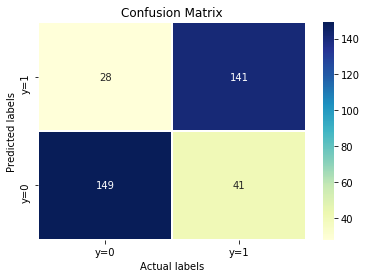

In [64]:
#Print confusion matrix (Code help from stackoverflow)
import seaborn as sns
import matplotlib.pyplot as plt     
fig = plt.figure()
ax= fig.add_subplot(111)
sns.heatmap(conf_matrix, annot=True, ax = ax, fmt="d",linewidths=1, cmap="YlGnBu"); #annot=True to annotate cells
ax.set_ylim([0,2]) # Workaround to display values in the center, to avoid downgrade to matplotlib3.1.1
ax.set_xlabel('Actual labels');
ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['y=0', 'y=1']); ax.yaxis.set_ticklabels(['y=0', 'y=1']);
plt.show()